In [2]:
import os, sys, platform, yaml, re
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, FloatType, StringType
from pathlib import Path
import matplotlib.pyplot as plt

# Preparación

In [3]:
conf_path = str(Path.cwd() / "config" / "ETL_config.yaml")
with open(conf_path, "r") as f:
    CFG = yaml.safe_load(f)

IS_WIN          = platform.system() == "Windows"
CSV_DIR         = CFG["paths"]["csv_base_dir"]["windows" if IS_WIN else "linux"]
PG_URL          = CFG["postgres"]["url"]
PG_USER         = CFG["postgres"]["user"]
PG_PASS         = CFG["postgres"]["pass"]
PG_SCHEMA       = CFG["postgres"]["schema_out"]["schema_name"]
PG_TABLE1       = CFG["postgres"]["schema_out"]["table1"]
PG_TABLE2       = CFG["postgres"]["schema_out"]["table2"]
PG_TABLE3       = CFG["postgres"]["schema_out"]["table3"]
FILES           = CFG["csv"]["files"]
NUM_PARTITIONS  = CFG["csv"]["num_partitions"]
JDBC_BATCHSIZE  = CFG["postgres"]["batchsize"]
JDBC_FETCHSIZE  = CFG["postgres"]["fetchsize"]
SPARK_LOCAL_DIR = CFG["spark"]["local_dirs"]["windows" if IS_WIN else "linux"]
NEO4J_URI  = CFG["neo4j"]["uri"]          # "bolt://localhost:7687"
NEO4J_USER = CFG["neo4j"]["user"]
NEO4J_PASS = CFG["neo4j"]["pass"]
NEO4J_DB   = CFG["neo4j"]["database"]

opts = {
    "url": NEO4J_URI,
    "authentication.type": "basic",
    "authentication.basic.username": NEO4J_USER,
    "authentication.basic.password": NEO4J_PASS,
    "database": NEO4J_DB,
}

os.environ["PYSPARK_PYTHON"] = sys.executable       # usa el Python del kernel actual
os.environ["JAVA_HOME"] = os.environ.get("JAVA_HOME", "/usr/lib/jvm/java-17-openjdk-amd64") #Chequear versión Windows después
Path(SPARK_LOCAL_DIR).mkdir(parents=True, exist_ok=True)


In [4]:
builder = (
    SparkSession.builder
    .master("local[*]")  
    .appName(CFG["spark"]["app_name"])
    .config("spark.sql.shuffle.partitions", str(CFG["spark"]["shuffle_partitions"]))
    .config("spark.driver.memory", CFG["spark"]["driver_memory"])
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.local.dir", SPARK_LOCAL_DIR)   
    #.config("spark.jars.packages", ",".join(CFG["spark"]["local_jars"]["linux"]))
    .config(
        "spark.jars.packages",
        ",".join([
            "org.postgresql:postgresql:42.7.4",
            "org.neo4j:neo4j-connector-apache-spark_2.12:5.3.10_for_spark_3"
        ])
    )
)

spark = builder.getOrCreate()
spark.sparkContext.setLogLevel("WARN")

jdbc_props = {
        "user": PG_USER,
        "password": PG_PASS,
        "driver": "org.postgresql.Driver",
        "fetchsize": str(JDBC_FETCHSIZE)
    }


25/11/12 18:14:02 WARN Utils: Your hostname, AsusMare resolves to a loopback address: 127.0.1.1; using 172.16.69.192 instead (on interface wlp2s0)
25/11/12 18:14:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark-3.5.3-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/felpipe/.ivy2/cache
The jars for the packages stored in: /home/felpipe/.ivy2/jars
org.postgresql#postgresql added as a dependency
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-eabf9923-2c25-4c78-a51c-9119a5700e16;1.0
	confs: [default]
	found org.postgresql#postgresql;42.7.4 in central
	found org.checkerframework#checker-qual;3.42.0 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in local-m2-cache
	found org.neo4j#caniuse-api;1.3.0 in local-m2-cache
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in local-m2-cache
	found org.jetbrains#annotations;13.0 in local-m2-cache
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in local-m2-cache
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in local-m2-cache
	

In [5]:
df_acc = (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE1}")
        .option("partitionColumn", "account")
        .option("lowerBound", 1)                  
        .option("upperBound", 2000000)
        .option("numPartitions", 16)               
        .options(**jdbc_props)
        .load())

df_txs = (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE2}")
        .option("partitionColumn", "id")
        .option("lowerBound", 1)
        .option("upperBound", 9500000)
        .option("numPartitions", 64)
        .options(**jdbc_props)
        .load())

acc_bounds = df_acc.select(
        F.min("account").cast("long").alias("lo"),
        F.max("account").cast("long").alias("hi")
    ).first()
acc_lo, acc_hi = int(acc_bounds["lo"]), int(acc_bounds["hi"])

df_sta =  (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE3}")
        .option("partitionColumn", "account")       # particionamos por cuenta
        .option("lowerBound", acc_lo)
        .option("upperBound", acc_hi)
        .option("numPartitions", 64)                 # ajústalo a tu máquina/cluster
        .options(**jdbc_props)
        .load()
        .select(
            F.col("account").cast("long").alias("account"),
            F.col("date_time").alias("date_time"),
            F.col("txn_id").cast("long").alias("txn_id"),
            F.col("direction").alias("direction"),
            F.col("delta_amount").cast("double").alias("delta_amount"),
            F.col("running_balance").cast("double").alias("running_balance")
        )
    )

# EDA Tabular

## Setup inicial y overview

In [5]:
# Verificar conteos básicos
print("Accounts:", df_acc.count())
print("Transactions:", df_txs.count())
print("Statements:", df_sta.count())

# Visualizar schemas y sample
df_acc.printSchema()
df_txs.printSchema()
df_sta.printSchema()

df_acc.show(5)
df_txs.show(5)
df_sta.show(5)

Accounts: 855460


Transactions: 9504852


Statements: 19009704
root
 |-- account: long (nullable = true)
 |-- location: string (nullable = true)

root
 |-- id: long (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- sender_account: long (nullable = true)
 |-- receiver_account: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- payment_currency: string (nullable = true)
 |-- received_currency: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- is_laundering: integer (nullable = true)
 |-- laundering_type: string (nullable = true)

root
 |-- account: long (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- txn_id: long (nullable = true)
 |-- direction: string (nullable = true)
 |-- delta_amount: double (nullable = true)
 |-- running_balance: double (nullable = true)

+-------+--------+
|account|location|
+-------+--------+
|  99278|      UK|
| 114277|      UK|
|  28511|      UK|
|  23159|      UK|
|  58673|      UK|
+-------+--------+
only showing top 5 rows

+

## Chequeo de missing values y duplicados

In [6]:
def null_summary(df, name: str, include_empty_strings: bool = True, show_pct: bool = True):
    # Identifica tipos por columna
    numeric_nan_cols = {
        f.name for f in df.schema.fields
        if isinstance(f.dataType, (DoubleType, FloatType))
    }
    string_cols = {
        f.name for f in df.schema.fields
        if isinstance(f.dataType, StringType)
    }

    # Construye expresiones por columna
    exprs = []
    for c in df.columns:
        cond = F.col(c).isNull()
        if c in numeric_nan_cols:
            cond = cond | F.isnan(c)
        if include_empty_strings and c in string_cols:
            cond = cond | (F.trim(F.col(c)) == "")
        exprs.append(F.sum(F.when(cond, 1).otherwise(0)).alias(c))

    # Ejecuta el cómputo
    counts = df.select(exprs).first().asDict()
    total = df.count()

    print(f"Resumen de valores nulos en '{name}':")
    for c in df.columns:
        n = int(counts[c])
        if show_pct and total > 0:
            pct = 100.0 * n / total
            print(f'  - "{c}": {n:,} ({pct:.2f}%)')
        else:
            print(f'  - "{c}": {n:,}')
    

null_summary(df_acc, "accounts")
null_summary(df_txs, "transactions")
null_summary(df_sta, "statements")

Resumen de valores nulos en 'accounts':
  - "account": 0 (0.00%)
  - "location": 0 (0.00%)


Resumen de valores nulos en 'transactions':
  - "id": 0 (0.00%)
  - "date_time": 0 (0.00%)
  - "sender_account": 0 (0.00%)
  - "receiver_account": 0 (0.00%)
  - "amount": 0 (0.00%)
  - "payment_currency": 0 (0.00%)
  - "received_currency": 0 (0.00%)
  - "payment_type": 0 (0.00%)
  - "is_laundering": 0 (0.00%)
  - "laundering_type": 0 (0.00%)


[Stage 30:==============================================>         (53 + 8) / 64]

Resumen de valores nulos en 'statements':
  - "account": 0 (0.00%)
  - "date_time": 0 (0.00%)
  - "txn_id": 0 (0.00%)
  - "direction": 0 (0.00%)
  - "delta_amount": 0 (0.00%)
  - "running_balance": 0 (0.00%)


In [7]:
# Duplicados
print("Duplicados accounts:", df_acc.count() - df_acc.dropDuplicates().count())
print("Duplicados transactions:", df_txs.count() - df_txs.dropDuplicates().count())
print("Duplicados statements:", df_sta.count() - df_sta.dropDuplicates().count())

Duplicados accounts: 0


Duplicados transactions: 0


[Stage 56:==============================================>          (9 + 2) / 11]

Duplicados statements: 0


## Verificación de claves y consistencia básica

In [8]:
# Verificar que todas las cuentas usadas en transacciones existen en df_acc
unique_tx_accounts = (
    df_txs
    .select(F.col("sender_account").alias("account"))
    .union(df_txs.select(F.col("receiver_account").alias("account")))
    .distinct()
)

missing_accounts = unique_tx_accounts.join(df_acc, "account", "left_anti")
print("Cuentas en transacciones no presentes en accounts:", missing_accounts.count())


[Stage 64:================================>                         (5 + 4) / 9]

Cuentas en transacciones no presentes en accounts: 0


## Tipificación y valores anómalos

In [9]:
print(f'Montos negativos o cero (si no debieran existir): {df_txs.filter(F.col("amount") <= 0).count()}')

print('Fechas fuera de rango')
df_txs.agg(
    F.min("date_time").alias("min_date"),
    F.max("date_time").alias("max_date")
).show()

print(f'Verificar transacciones con misma cuenta de origen y destino: {df_txs.filter(F.col("sender_account") == F.col("receiver_account")).count()}')


Montos negativos o cero (si no debieran existir): 0
Fechas fuera de rango


+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2022-10-07 10:35:19|2023-08-23 10:57:12|
+-------------------+-------------------+



[Stage 75:=================================================>      (56 + 8) / 64]

Verificar transacciones con misma cuenta de origen y destino: 0


## Análisis univariado: Accounts

La clave única para la columna accounts es account, por lo tanto en efecto deberían haber tantas cuentas como filas.

In [10]:
print(f'Cantidad distinta de cuentas en el set de datos: {df_acc.select(F.col("account")).distinct().count():,}'.replace(',','.'))

[Stage 78:====================================================>   (15 + 1) / 16]

Cantidad distinta de cuentas en el set de datos: 855.460


In [11]:
df_acc \
    .select(F.col('location')) \
    .groupby(F.col('location')) \
    .count().show()

+-----------+------+
|   location| count|
+-----------+------+
|         UK|803407|
|    Austria|  3072|
|      India|  3057|
|    Germany|  3051|
|   Pakistan|  3100|
|      Spain|  3066|
|Netherlands|  3006|
|     Mexico|  3149|
|     Turkey|  3072|
|Switzerland|  3053|
|        USA|  3056|
|    Morocco|  3031|
|      Japan|  3095|
|    Nigeria|  3111|
|        UAE|  3042|
|    Albania|  3086|
|      Italy|  2968|
|     France|  3038|
+-----------+------+



In [12]:
print(f'El set contiene {df_acc.select(F.col("location")).distinct().count()} localidades diferentes')

El set contiene 18 localidades diferentes


Conviene, más tarde, codificar estas localidades con hash de 5 bits. La distribución de probabilidades es bastante uniforme en el set completo, excepto para UK con la que tiene un sesgo enorme. Esta columna se pone a riesgo de ser poco informativa, por lo que el set se vuelve candidato de aumento de datos solo por esta columna. La alternativa es eliminarla.

## Análisis univariado: Transferencias

De manera similar, hacemos las cuentas con el id de la transacción.

In [13]:
print(f'Cantidad distinta de cuentas en el set de datos: {df_txs.select(F.col("id")).distinct().count():,}'.replace(',','.'))

[Stage 95:>                                                         (0 + 8) / 9]

Cantidad distinta de cuentas en el set de datos: 9.504.852


In [14]:
print('Fechas mínima y máximas del dataset')
df_txs.agg(
    F.min("date_time").alias("min_date"),
    F.max("date_time").alias("max_date")
).show()

df_txs.agg(
        (F.datediff(F.max("date_time"), F.min("date_time"))).alias("dias_entre_fechas")
    ).show()

Fechas mínima y máximas del dataset


+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2022-10-07 10:35:19|2023-08-23 10:57:12|
+-------------------+-------------------+



[Stage 102:================================================>      (56 + 8) / 64]

+-----------------+
|dias_entre_fechas|
+-----------------+
|              320|
+-----------------+



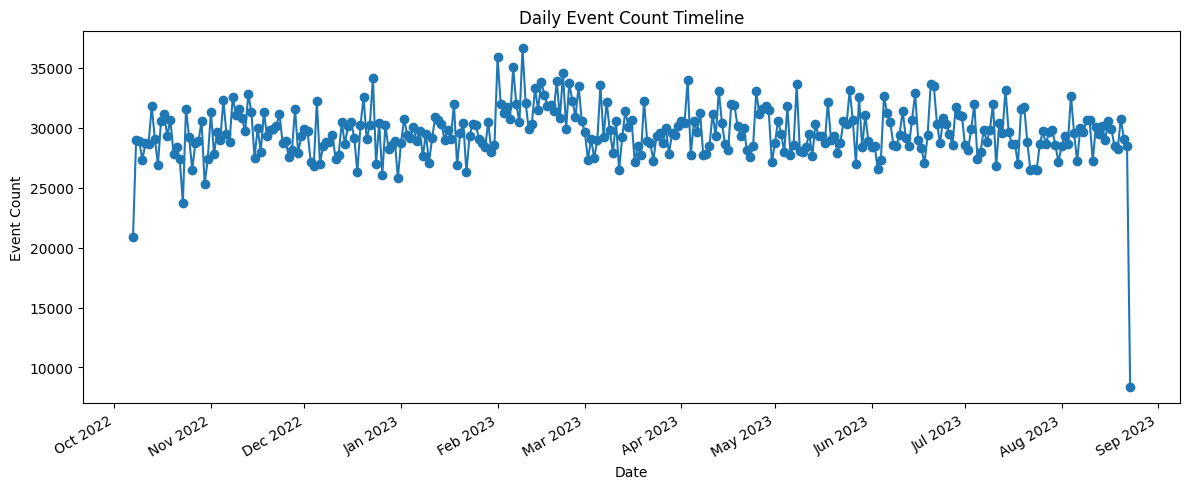

In [15]:
df_daily = df_txs.groupBy(
    F.to_date("date_time").alias("day")
).agg(
    F.count("*").alias("event_count")
).orderBy("day")

pdf_daily = df_daily.toPandas()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(pdf_daily["day"], pdf_daily["event_count"], marker='o')
ax.set_title("Daily Event Count Timeline")
ax.set_xlabel("Date")
ax.set_ylabel("Event Count")

# Format x-axis to show month and year
ax.xaxis.set_major_formatter(
    plt.matplotlib.dates.DateFormatter('%b %Y')
)
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

Se nota una cantidad más o menos constante de transferencias por día. Al ser datos sintéticos estos siguen ciertas condiciones que normalmente parecerían ideales.

In [16]:
print(f"Número de cuentas diferentes que envían: {df_txs.select(F.col('sender_account')).distinct().count()}")

[Stage 113:================================================>      (56 + 8) / 64]

Número de cuentas diferentes que envían: 292715


In [17]:
print(f"Número de cuentas diferentes que envían: {df_txs.select(F.col('receiver_account')).distinct().count()}")

[Stage 119:================================================>      (56 + 8) / 64]

Número de cuentas diferentes que envían: 652266


Existe un fuerte desbalance entre la cantidad de cuentas que envían vs las que reciben ~2:1. Chequear el número de hubs y la cantidad de éstos en el dataset en comparación con el resto de nodos. Revisar el EDA grafo para este detalle.

In [18]:
df_txs.agg(
    F.min("amount").alias("min_amount"),
    F.max("amount").alias("max_amount")
).show()

[Stage 125:================================================>      (56 + 8) / 64]

+----------+------------+
|min_amount|  max_amount|
+----------+------------+
|      3.73|1.26184984E7|
+----------+------------+



In [19]:
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]

# Cuantiles usando los valores originales de 'amount'
amount_quantiles = df_txs.approxQuantile("amount", quantiles, 0.01)

# Cuantiles usando logaritmo natural de 'amount'
df_log = df_txs.select(F.log10(F.col('amount')).alias('log_amount'))
log_quantiles = df_log.approxQuantile("log_amount", quantiles, 0.01)

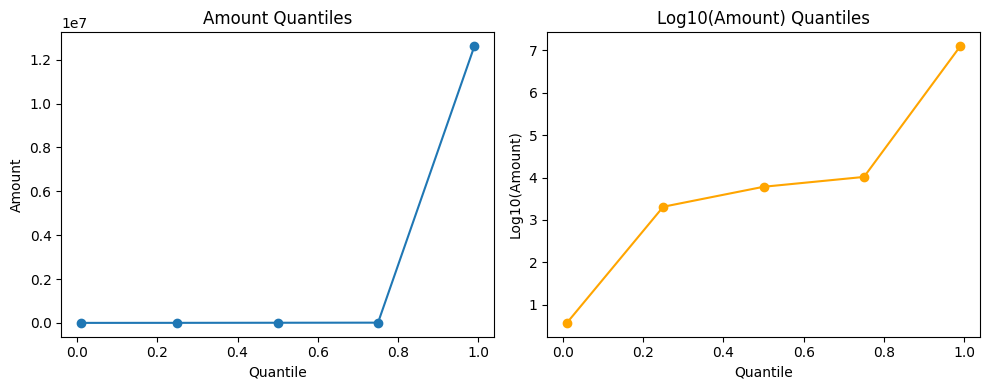

In [20]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 4)
)

# Plot quantiles of 'amount'
axes[0].plot(
    quantiles,
    amount_quantiles,
    marker='o'
)
axes[0].set_title('Amount Quantiles')
axes[0].set_xlabel('Quantile')
axes[0].set_ylabel('Amount')

# Plot quantiles of log10('amount')
axes[1].plot(
    quantiles,
    log_quantiles,
    marker='o',
    color='orange'
)
axes[1].set_title('Log10(Amount) Quantiles')
axes[1].set_xlabel('Quantile')
axes[1].set_ylabel('Log10(Amount)')

plt.tight_layout()
plt.show()

Existe una marcada diferencia exponencial con respecto a cada cuantil. El gráfico en unidades absolutas es inútil a la hora de hacer seguimiento. Como la diferencia se presenta más o menos lineal en los cuantiles se concluye que conviene mantener esta transformación para trabajar con esta variable.

In [21]:
df_txs \
    .groupby(F.col('payment_currency')) \
    .count() \
    .orderBy(F.col('payment_currency')) \
    .show()

[Stage 132:======================================================>(63 + 1) / 64]

+----------------+-------+
|payment_currency|  count|
+----------------+-------+
|    Albanian lek|  24778|
|          Dirham|  27263|
|            Euro| 117164|
|    Indian rupee|  24657|
|    Mexican Peso|  24852|
| Moroccan dirham|  25395|
|           Naira|  27143|
| Pakistani rupee|  27196|
|     Swiss franc|  27492|
|    Turkish lira|  27996|
|       UK pounds|9099293|
|       US dollar|  26061|
|             Yen|  25562|
+----------------+-------+



In [22]:
df_txs \
    .groupby(F.col('received_currency')) \
    .count() \
    .orderBy(F.col('received_currency')) \
    .show()

[Stage 135:================================================>      (56 + 8) / 64]

+-----------------+-------+
|received_currency|  count|
+-----------------+-------+
|     Albanian lek|  45736|
|           Dirham|  42797|
|             Euro| 231911|
|     Indian rupee|  43757|
|     Mexican Peso|  45255|
|  Moroccan dirham|  45748|
|            Naira|  45046|
|  Pakistani rupee|  45993|
|      Swiss franc|  42931|
|     Turkish lira|  42545|
|        UK pounds|8783655|
|        US dollar|  43664|
|              Yen|  45814|
+-----------------+-------+



Tanto para la moneda de pago como para la de recepción se puede observar que, nuevamente, el set de datos se mantiene uniforme en la mayoría de los casos. Solamente el euro y las libras esterlinas presentan diferencias, y además se muestran con un gran sesgo, en especial la segunda. Además, salvo por las libras, todas las otras monedas pasan a repetir el patrón 2:1 que se observó entre cuentas que envían y cuentas que reciben. 

Estas simetrías levantan fuertes sospechas sobre las capacidades de generalización a datos reales. Sin embargo, para poder probar códigos, parece ser un buen set de datos.

Se sugiere colapsar las categorías a [Euro, UK punds, Otros], a la hora de codificar. Pero ver realmente esto con las variables objetivo en el análisis bivariado.

In [23]:
df_txs \
    .groupby(F.col('payment_type')) \
    .count() \
    .show()

[Stage 138:==============================================>        (54 + 8) / 64]

+---------------+-------+
|   payment_type|  count|
+---------------+-------+
|Cash Withdrawal| 300477|
|     Debit card|2012103|
|   Cash Deposit| 225206|
|   Cross-border| 933931|
|    Credit card|2012909|
|         Cheque|2011419|
|            ACH|2008807|
+---------------+-------+



Existe cierta uniformidad de los datos, en especial aquellos cercanos a los 2M. No obstante hay también algunos sesgos, por lo que podrían haber patrones.

In [24]:
df_txs \
    .groupby(F.col('is_laundering')) \
    .count() \
    .show()

[Stage 141:======================================================>(63 + 1) / 64]

+-------------+-------+
|is_laundering|  count|
+-------------+-------+
|            0|9494979|
|            1|   9873|
+-------------+-------+



Esto es algo esperable, y sabido para este tipo de problemas. La variable objetivo está tremendamente sesgada y los ejemplos positivos, son muy escasos. Se trata de una oportunidad para practicar ténicas. Primero conviene validar modelos que pueden funcionar con estos pocos datos, y luego verificar si es posible enmascararlos para aplicar técnicas de aprendizaje semisupervizado.

In [25]:
df_txs \
    .groupby(F.col('laundering_type')) \
    .count() \
    .orderBy(F.col('laundering_type')) \
    .show()

[Stage 144:==============================================>        (54 + 8) / 64]

+--------------------+-------+
|     laundering_type|  count|
+--------------------+-------+
|Behavioural_Change_1|    394|
|Behavioural_Change_2|    345|
|           Bipartite|    383|
|     Cash_Withdrawal|   1334|
|               Cycle|    382|
|        Deposit-Send|    945|
|              Fan_In|    364|
|             Fan_Out|    237|
|      Gather-Scatter|    354|
|      Layered_Fan_In|    656|
|     Layered_Fan_Out|    529|
|Normal_Cash_Deposits| 223801|
|Normal_Cash_Withd...| 305031|
|       Normal_Fan_In|2104285|
|      Normal_Fan_Out|2302220|
|       Normal_Foward|  42031|
|        Normal_Group| 528351|
|       Normal_Mutual| 125335|
|   Normal_Periodical| 210526|
|  Normal_Plus_Mutual| 155041|
+--------------------+-------+
only showing top 20 rows



Una alternativa a clasificar de manera binaria es con categorías. El set de datos permite atacar ese problema si el primero resulta ser muy fácil. Es una característica curiosa y útil si se busca mejorar.

## Análisis Bivariado

In [26]:
cross_tab = (
    df_txs
    .groupBy('sender_account')
    .agg(
        F.count('*').alias('total_tx'),
        F.sum(F.when(F.col('is_laundering') == 1, 1).otherwise(0)).alias('fraud_tx'),
        F.sum(F.when(F.col('is_laundering') == 0, 1).otherwise(0)).alias('nonfraud_tx')
    )
    .withColumn('fraud_rate', F.col('fraud_tx') / F.col('total_tx'))
    .orderBy(F.desc('fraud_rate'))
)

cross_tab.show(20, truncate=False)

[Stage 147:======================================================>(63 + 1) / 64]

+--------------+--------+--------+-----------+------------------+
|sender_account|total_tx|fraud_tx|nonfraud_tx|fraud_rate        |
+--------------+--------+--------+-----------+------------------+
|5917350547    |9       |9       |0          |1.0               |
|2247370907    |24      |23      |1          |0.9583333333333334|
|4159678387    |40      |37      |3          |0.925             |
|2488893433    |29      |26      |3          |0.896551724137931 |
|5008453588    |28      |25      |3          |0.8928571428571429|
|3864360347    |23      |20      |3          |0.8695652173913043|
|4220180108    |7       |6       |1          |0.8571428571428571|
|1865451606    |28      |24      |4          |0.8571428571428571|
|5262095561    |31      |26      |5          |0.8387096774193549|
|7147448786    |31      |26      |5          |0.8387096774193549|
|9710838491    |37      |31      |6          |0.8378378378378378|
|7348501127    |6       |5       |1          |0.8333333333333334|
|573399182

Esto revela algo interesante, un poco obvio, pero importante que esté presente en los datos. Hay cuentas con marcada tendencia a enviar transferencias fraudulentas.

In [31]:
cross_tab = (
    df_txs
    .groupBy('receiver_account')
    .agg(
        F.count('*').alias('total_tx'),
        F.sum(F.when(F.col('is_laundering') == 1, 1).otherwise(0)).alias('fraud_tx'),
        F.sum(F.when(F.col('is_laundering') == 0, 1).otherwise(0)).alias('nonfraud_tx')
    )
    .withColumn('fraud_rate', F.col('fraud_tx') / F.col('total_tx'))
    .orderBy(F.desc('fraud_tx'))
)

cross_tab.show(20, truncate=False)

[Stage 167:================================================>      (56 + 8) / 64]

+----------------+--------+--------+-----------+-------------------+
|receiver_account|total_tx|fraud_tx|nonfraud_tx|fraud_rate         |
+----------------+--------+--------+-----------+-------------------+
|6844529387      |58      |47      |11         |0.8103448275862069 |
|1665774528      |47      |45      |2          |0.9574468085106383 |
|6123421761      |45      |44      |1          |0.9777777777777777 |
|8227126673      |65      |42      |23         |0.6461538461538462 |
|3790148325      |47      |41      |6          |0.8723404255319149 |
|2531548770      |41      |40      |1          |0.975609756097561  |
|1142779963      |59      |38      |21         |0.6440677966101694 |
|6644790956      |44      |38      |6          |0.8636363636363636 |
|7859972869      |49      |38      |11         |0.7755102040816326 |
|270405806       |47      |37      |10         |0.7872340425531915 |
|3546293157      |54      |37      |17         |0.6851851851851852 |
|2311552997      |59      |36     

Salvo para dos cuentas en particular, el patrón no se repite con los receptores. Esto va acorde con la intuición para las cuentas normales, aunque también habría de esperar que hubieran algunas cuentas fraudulentas especializadas en la recepción de transferencias fraudulentas. En cambio, el set de datos señala que la recepción es totalmente pasiva.

Estas dos variables tienen una cardinalidad muy alta, por lo que el análisis solo conviene dejarlo de manera descriptivo de momento. De todas maneras, a simple vista y bien ordenado, hay unas pocas cuentas que resalta que son altamente fraudulentas ya sea que fuesen receptoras o emisoras.

In [32]:
df_txs = df_txs.withColumn(
    "log_amount",
    F.log10(F.when(F.col("amount") > 0, F.col("amount")).otherwise(None))
)

In [33]:
summary = (
    df_txs
    .groupBy("is_laundering")
    .agg(
        F.count("*").alias("n"),
        F.mean("amount").alias("mean_amount"),
        F.expr("percentile(amount, 0.5)").alias("median_amount"),
        F.expr("percentile(amount, array(0.25, 0.75))").alias("q25_q75"),
        F.mean("log_amount").alias("mean_log_amount"),
        F.expr("percentile(log_amount, array(0.25, 0.5, 0.75))").alias("log_percentiles")
    )
)

In [35]:
# Conteo por clase
counts = df_txs.groupBy("is_laundering").count().collect()
fraud_n = [r["count"] for r in counts if r["is_laundering"] == 1][0]
nonfraud_n = [r["count"] for r in counts if r["is_laundering"] == 0][0]

# Fracción de muestreo por clase
target_n = 50000
frac_fraud = min(1.0, target_n / fraud_n)
frac_nonfraud = min(1.0, target_n / nonfraud_n)

sample = (df_txs
          .sampleBy("is_laundering", fractions={0: frac_nonfraud, 1: frac_fraud}, seed=42)
          .select("is_laundering", "amount", "log_amount"))

# Convertimos la muestra a pandas para graficar
pdf = sample.toPandas()


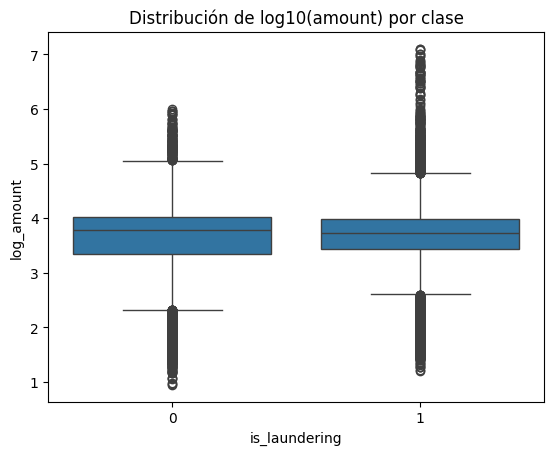

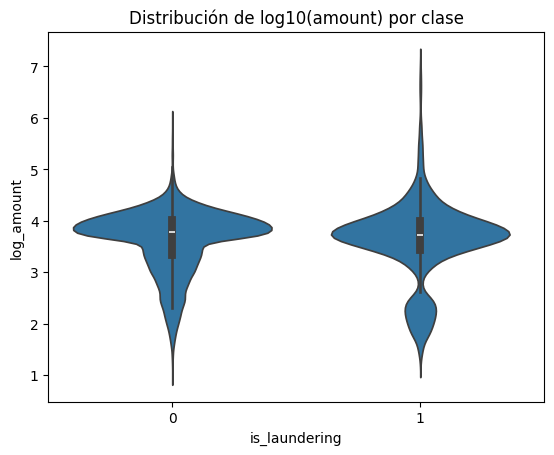

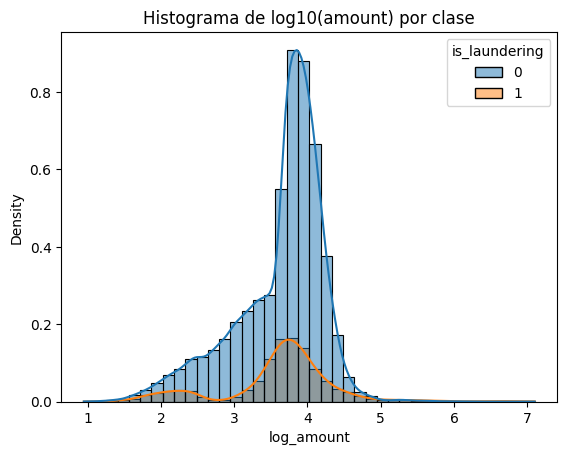

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot
sns.boxplot(x="is_laundering", y="log_amount", data=pdf)
plt.title("Distribución de log10(amount) por clase")
plt.show()

# Violinplot
sns.violinplot(x="is_laundering", y="log_amount", data=pdf)
plt.title("Distribución de log10(amount) por clase")
plt.show()

# Histograma con KDE
sns.histplot(data=pdf, x="log_amount", hue="is_laundering", bins=40, kde=True, stat="density")
plt.title("Histograma de log10(amount) por clase")
plt.show()


Hay un leve corrimiento entre las modas de los montos de los grupos de transacciones. En general, la distribución de los montos comunes tiene una moda mayor, pero también tiene muchísima más presencia de valores bajos. Por el contrario, si bien en similitud los montos de las transferencias fraudulentas caen muy cerca del grupo grande de las tranferencias no fraudulentas, se observan muy pocas, o despreciables cantidades de transferencias fraudulentas de bajo valor. Por otro lado, las distribuciones de probabilidad no son iguales, lo que permite que el reconocimiento automático pueda servirse de estos patrones.

Debido a que las columnas de estas variables son muy uniformes resultan poco informativas, exceptuando aquellas de grandes sesgos. Por lo tanto se colapsan.

In [37]:
def collapse_currency(colname):
    c = F.trim(F.lower(F.col(colname)))
    return (
        F.when(c.isin("euro", "eur", "€"), F.lit("Euro"))
         .when(c.isin("uk pounds", "gbp", "british pound", "pound sterling", "uk pound", "£"), F.lit("UK pounds"))
         .otherwise(F.lit("Other"))
    )

df_curr = (df_txs
           .withColumn("payment_currency_3", collapse_currency("payment_currency"))
           .withColumn("received_currency_3", collapse_currency("received_currency")))

In [38]:
(df_curr.groupBy("payment_currency_3").count().orderBy(F.desc("count")).show(truncate=False))
(df_curr.groupBy("received_currency_3").count().orderBy(F.desc("count")).show(truncate=False))

+------------------+-------+
|payment_currency_3|count  |
+------------------+-------+
|UK pounds         |9099293|
|Other             |288395 |
|Euro              |117164 |
+------------------+-------+



[Stage 180:================================================>      (57 + 7) / 64]

+-------------------+-------+
|received_currency_3|count  |
+-------------------+-------+
|UK pounds          |8783655|
|Other              |489286 |
|Euro               |231911 |
+-------------------+-------+



In [39]:
contingency_payment = (
    df_curr
    .groupBy("payment_currency_3", "is_laundering")
    .count()
    .withColumnRenamed("count", "obs")
)

contingency_payment.show()


[Stage 183:====================================================>  (61 + 3) / 64]

+------------------+-------------+-------+
|payment_currency_3|is_laundering|    obs|
+------------------+-------------+-------+
|              Euro|            0| 116904|
|             Other|            0| 287612|
|              Euro|            1|    260|
|         UK pounds|            1|   8830|
|             Other|            1|    783|
|         UK pounds|            0|9090463|
+------------------+-------------+-------+



In [40]:
def chi2_cramers_v_spark(df, row_col, col_col):
    # 1) Observados
    obs = (df
           .groupBy(row_col, col_col)
           .count()
           .withColumnRenamed("count", "obs"))

    # 2) Totales
    row_tot = obs.groupBy(row_col).agg(F.sum("obs").alias("row_total"))
    col_tot = obs.groupBy(col_col).agg(F.sum("obs").alias("col_total"))
    n = obs.agg(F.sum("obs").alias("n")).first()["n"]

    # 3) Esperados y contribución chi²
    contrib = (obs
               .join(row_tot, on=row_col, how="left")
               .join(col_tot, on=col_col, how="left")
               .withColumn("expected", (F.col("row_total") * F.col("col_total")) / F.lit(n))
               .withColumn("chi2_term", (F.col("obs") - F.col("expected"))**2 / F.col("expected")))

    chi2 = contrib.agg(F.sum("chi2_term").alias("chi2")).first()["chi2"]

    # 4) Grados de libertad y Cramer’s V corregido
    r = obs.select(row_col).distinct().count()
    k = obs.select(col_col).distinct().count()
    dof = (r - 1) * (k - 1)

    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    cramers_v = (phi2corr / max(1e-12, min(kcorr - 1, rcorr - 1))) ** 0.5

    return {
        "n": n,
        "r": r,
        "k": k,
        "dof": dof,
        "chi2": chi2,
        "cramers_v": cramers_v
    }


In [41]:
res_payment = chi2_cramers_v_spark(df_curr, "payment_currency_3", "is_laundering")
print("payment_currency_3 vs is_laundering →", res_payment)


[Stage 219:================================================>      (56 + 8) / 64]

payment_currency_3 vs is_laundering → {'n': 9504852, 'r': 3, 'k': 2, 'dof': 2, 'chi2': 979.2322746991276, 'cramers_v': 0.010139726579451842}


In [42]:
res_received = chi2_cramers_v_spark(df_curr, "received_currency_3", "is_laundering")
print("received_currency_3 vs is_laundering →", res_received)


[Stage 258:===========================================>           (51 + 8) / 64]

received_currency_3 vs is_laundering → {'n': 9504852, 'r': 3, 'k': 2, 'dof': 2, 'chi2': 7364.682994330542, 'cramers_v': 0.0278320627192485}


Si bien los resultados de chi cuadrado indican que incluso diferencias minúsculas se vuelven significativas con este tamaño de datasets la prueba de Cramer para ambas variables indica fuerzas de relación prácticamente nulas. En otras palabras, se pueden eliminar pues ni el tipo de moneda en que se paga (payment_currency_3) no distingue bien entre operaciones fraudulentas y legítimas ni la moneda recibida lo hace.

In [43]:
res_payment_type = chi2_cramers_v_spark(df_txs, "payment_type", "is_laundering")
print("payment_type vs is_laundering →", res_payment_type)

[Stage 303:===================================================>   (60 + 4) / 64]

payment_type vs is_laundering → {'n': 9504852, 'r': 7, 'k': 2, 'dof': 6, 'chi2': 13831.7199453386, 'cramers_v': 0.03813916856467434}


El tipo de pago parece tener alguna leve tendencia: quizá ciertas formas de pago concentran un poco más de transacciones sospechosas, pero el efecto global es minúsculo.

Es probable que el fraude esté algo más presente en uno o dos payment_type específicos (por ejemplo, “wire transfer” o “online”), pero no domina el patrón general.

En la práctica, payment_type por sí sola no discrimina bien entre fraude y no fraude.

In [64]:
df_txs.columns

['id',
 'date_time',
 'sender_account',
 'receiver_account',
 'amount',
 'payment_currency',
 'received_currency',
 'payment_type',
 'is_laundering',
 'laundering_type']

In [ ]:
res = chi2_cramers_v_spark(df_txs, "transaction_type", "is_laundering")
print(res)

In [ ]:
def chi2_cramers_v_spark(df, row_col, col_col):
    # 1) Conteos observados
    obs = (df
           .groupBy(row_col, col_col)
           .count()
           .withColumnRenamed("count", "obs"))

    # 2) Totales por fila/columna y total global
    row_tot = obs.groupBy(row_col).agg(F.sum("obs").alias("row_total"))
    col_tot = obs.groupBy(col_col).agg(F.sum("obs").alias("col_total"))
    n = obs.agg(F.sum("obs").alias("n")).first()["n"]

    # 3) Esperados y contribución χ²
    contrib = (obs
               .join(row_tot, on=row_col, how="left")
               .join(col_tot, on=col_col, how="left")
               .withColumn("expected", (F.col("row_total") * F.col("col_total")) / F.lit(n))
               .withColumn("chi2_term", (F.col("obs") - F.col("expected"))**2 / F.col("expected")))

    chi2 = contrib.agg(F.sum("chi2_term").alias("chi2")).first()["chi2"]

    # 4) Grados de libertad y Cramer’s V (con corrección)
    r = obs.select(row_col).distinct().count()
    k = obs.select(col_col).distinct().count()
    dof = (r - 1) * (k - 1)

    # Cramer’s V corregido
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    denom = max(1e-12, min(kcorr - 1, rcorr - 1))  # evita división por cero si r==1 o k==1
    cramers_v = (phi2corr / denom) ** 0.5

    return {
        "chi2": chi2,
        "dof": dof,
        "n": n,
        "r": r,
        "k": k,
        "cramers_v": cramers_v
    }

# EDA topológico

In [6]:

df_nodes = (
    spark.read.format("org.neo4j.spark.DataSource")
    .options(**opts)
    .option("query", "MATCH (n) LIMIT 5 RETURN id(n) AS id, labels(n) AS labels")
    .load()
)
df_nodes.show(truncate=False)


+---+---------+
|id |labels   |
+---+---------+
|0  |[Account]|
|1  |[Account]|
|2  |[Account]|
|3  |[Account]|
|4  |[Account]|
+---+---------+



In [8]:
df_nodes = (
    spark.read.format("org.neo4j.spark.DataSource")
    .options(**opts)
    .option("query", "MATCH (n) -[r:TX]-> (m) LIMIT 1 RETURN n, r, m")
    .load()
)
df_nodes.show(truncate=False)

+----------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|n                                                                                             |r                                                                                                                                 